In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

project_root = Path("..").resolve()
sys.path.append(str(project_root))

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("mps" if torch.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


In [20]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(
    root="../data/raw",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root="../data/raw",
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))

Train samples: 60000
Test samples: 10000


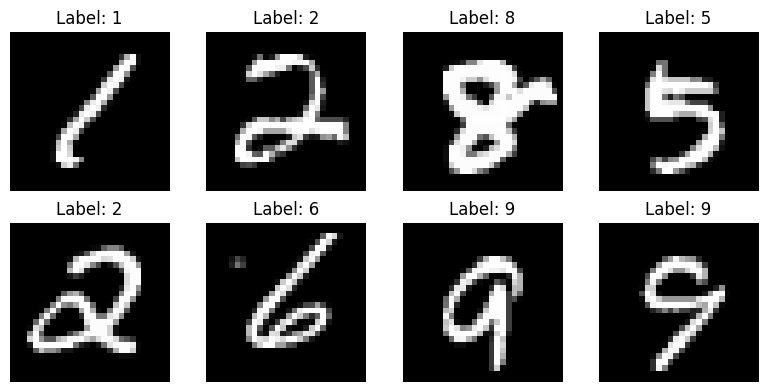

In [21]:
examples = next(iter(train_loader))
images, labels = examples

plt.figure(figsize=(8, 4))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i][0], cmap="gray")
    plt.title(f"Label: {labels[i].item()}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [22]:
from models.mnist_cnn import MNISTCNN

model = MNISTCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

MNISTCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [23]:
def train(model, loader):
    model.train()
    total_loss = 0

    for data, target in loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

In [24]:
def test(model, loader):
    model.eval()
    correct = 0

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            preds = output.argmax(dim=1)
            correct += preds.eq(target).sum().item()

    accuracy = correct / len(loader.dataset)
    return accuracy

In [25]:
epochs = 5

for epoch in range(1, epochs + 1):
    loss = train(model, train_loader)
    acc = test(model, test_loader)

    print(f"Epoch {epoch}: Loss={loss:.4f}, Test Accuracy={acc:.4f}")

Epoch 1: Loss=0.1169, Test Accuracy=0.9845
Epoch 2: Loss=0.0354, Test Accuracy=0.9876
Epoch 3: Loss=0.0222, Test Accuracy=0.9889
Epoch 4: Loss=0.0155, Test Accuracy=0.9914
Epoch 5: Loss=0.0115, Test Accuracy=0.9898


In [26]:
model_path = "../models/mnist_cnn.pt"
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")

Model saved to ../models/mnist_cnn.pt


In [27]:
loaded_model = MNISTCNN().to(device)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()

acc = test(loaded_model, test_loader)
print("Reloaded model accuracy:", acc)

Reloaded model accuracy: 0.9898
